## МЕТОД ГЛАВНЫХ КОМПОНЕНТ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train, validation, test = load_mnist()
X = train[0]  
labels = train[1]  

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [3]:
print(X.shape, labels.shape)

(55000, 28, 28, 1) (55000,)


# I. Визуализация датасета

Нарисуем несколько примеров картинок из X_train

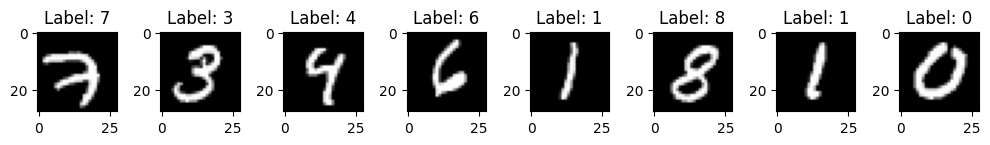

In [7]:
num_examples = 8

fig, axes = plt.subplots(nrows=1, ncols=num_examples, figsize=(10, 2))

for i in range(num_examples):
    image = X[i]
    label = labels[i]

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

# II. Алгоритм PCA

Реализация алгоритма PCA 

In [8]:
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.components = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)

        centered_X = X - self.mean

        cov_matrix = np.dot(centered_X.T, centered_X) / (centered_X.shape[0] - 1)

        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        if self.n_components is not None:
            self.components = sorted_eigenvectors[:, :self.n_components]
        else:
            self.components = sorted_eigenvectors

    def transform(self, X):
        centered_X = X - self.mean
        transformed_X = np.dot(centered_X, self.components)

        return transformed_X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

Строим график собственных значений и график кумулятивной суммы собственных значений

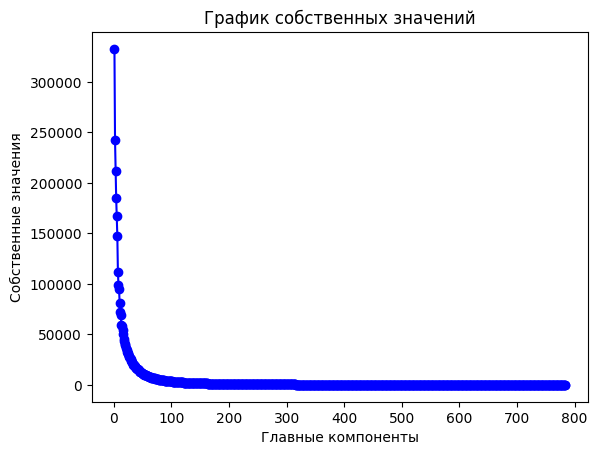

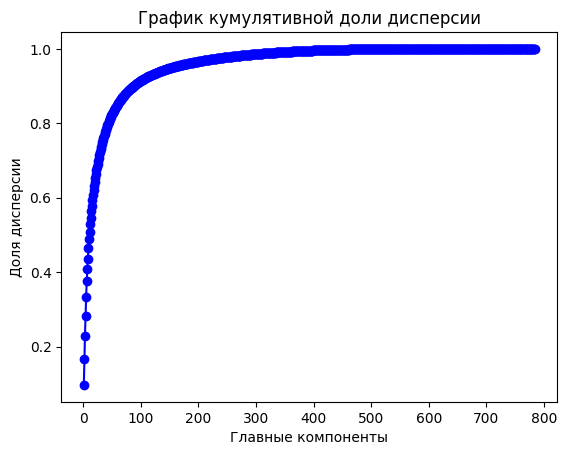

Доля дисперсии, покрываемая первыми 15 главными компонентами: 0.5791247436307819


In [9]:
X_2d = np.reshape(X, (X.shape[0], -1))

cov_matrix = np.cov(X_2d.T)

eigenvalues = np.linalg.eigvals(cov_matrix)

sorted_eigenvalues = np.sort(eigenvalues)[::-1]

plt.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', linestyle='-', color='b')
plt.xlabel('Главные компоненты')
plt.ylabel('Собственные значения')
plt.title('График собственных значений')
plt.show()

total_variance = np.sum(sorted_eigenvalues)
cumulative_variance = np.cumsum(sorted_eigenvalues) / total_variance

plt.plot(range(1, len(sorted_eigenvalues) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Главные компоненты')
plt.ylabel('Доля дисперсии')
plt.title('График кумулятивной доли дисперсии')
plt.show()

total_variance = np.sum(sorted_eigenvalues)
variance_covered = np.sum(sorted_eigenvalues[:15]) / total_variance
print(f"Доля дисперсии, покрываемая первыми 15 главными компонентами: {variance_covered}")

Выводим изображение точек датасета в первых двух координатах главных компонент

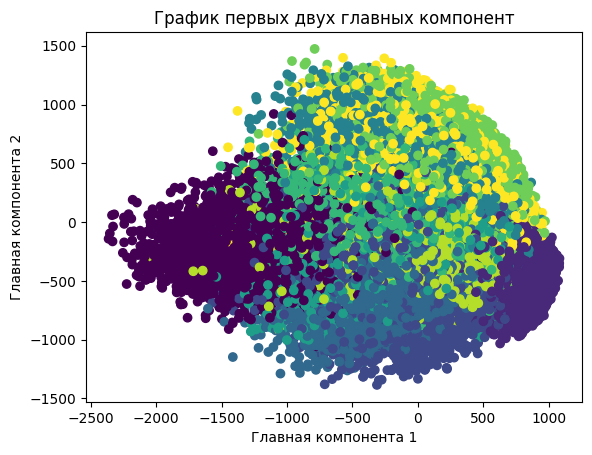

In [10]:
def plot_pca_scatter(X_pca, labels):
    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=str(label))
    plt.xlabel('Главная компонента 1')
    plt.ylabel('Главная компонента 2')
    plt.title('График первых двух главных компонент')
    plt.legend()
    plt.show()

X_2d = np.reshape(X, (X.shape[0], -1))

pca = my_PCA(n_components=2)
pca.fit(X_2d)
X_pca = pca.transform(X_2d)

colors = labels.astype(int)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('График первых двух главных компонент')
plt.show()

# III. Алгоритм kNN

Реализация алгоритма kNN

In [11]:
class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for x_test in X_test:
            distances = np.linalg.norm(self.X_train - x_test, axis=1)

            nearest_indices = np.argsort(distances)[:self.n_neighbors]

            nearest_labels = self.y_train[nearest_indices]

            y_pred.append(np.bincount(nearest_labels).argmax())

        return np.array(y_pred)

Разбиваем данные на обучающую и тестовую выборку

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.05, random_state=42)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(52250, 28, 28, 1) (52250,)
(2750, 28, 28, 1) (2750,)


Создаем и обучаем классификатор kNN. Предсказываем на тестовой выборке и оцениваем точность алгоритма kNN

In [29]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

pca = my_PCA(n_components=1)
pca.fit(X_train_flat)
X_train_pca = pca.transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

knn = my_kNN(n_neighbors=5)

knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность алгоритма: {accuracy}")

Точность алгоритма: 0.2778181818181818


In [30]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

pca = my_PCA(n_components=2)
pca.fit(X_train_flat)
X_train_pca = pca.transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

knn = my_kNN(n_neighbors=5)

knn.fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Точность алгоритма: {accuracy}")

Точность алгоритма: 0.4112727272727273


In [23]:
accuracies = np.zeros((8, 5))

best_accuracy = 0.0
best_components = 0
best_neighbors = 0

for n_components in range(8, 65, 8):
    for n_neighbors in range(6, 31, 6):
        pca = my_PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
        X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

        knn = my_kNN(n_neighbors=n_neighbors)

        knn.fit(X_train_pca, y_train)

        y_pred = knn.predict(X_test_pca)

        accuracy = accuracy_score(y_test, y_pred)

        accuracies[(n_components // 8) - 1, (n_neighbors // 6) - 1] = accuracy

        print("Компоненты: {}, Соседи: {}, Точность: {}".format(n_components, n_neighbors, accuracy))

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_components = n_components
            best_neighbors = n_neighbors

print(f"\nНаилучшая точность: {best_accuracy}")
print(f"Количество компонент при наилучшей точности: {best_components}")
print(f"Количество соседей при наилучшей точности: {best_neighbors}")

Компоненты: 8, Соседи: 6, Точность: 0.904
Компоненты: 8, Соседи: 12, Точность: 0.9054545454545454
Компоненты: 8, Соседи: 18, Точность: 0.9043636363636364
Компоненты: 8, Соседи: 24, Точность: 0.9018181818181819
Компоненты: 8, Соседи: 30, Точность: 0.8989090909090909
Компоненты: 16, Соседи: 6, Точность: 0.9650909090909091
Компоненты: 16, Соседи: 12, Точность: 0.9621818181818181
Компоненты: 16, Соседи: 18, Точность: 0.9603636363636363
Компоненты: 16, Соседи: 24, Точность: 0.9570909090909091
Компоненты: 16, Соседи: 30, Точность: 0.9545454545454546
Компоненты: 24, Соседи: 6, Точность: 0.9756363636363636
Компоненты: 24, Соседи: 12, Точность: 0.9709090909090909
Компоненты: 24, Соседи: 18, Точность: 0.9665454545454546
Компоненты: 24, Соседи: 24, Точность: 0.9665454545454546
Компоненты: 24, Соседи: 30, Точность: 0.9658181818181818
Компоненты: 32, Соседи: 6, Точность: 0.9741818181818181
Компоненты: 32, Соседи: 12, Точность: 0.9730909090909091
Компоненты: 32, Соседи: 18, Точность: 0.9709090909090

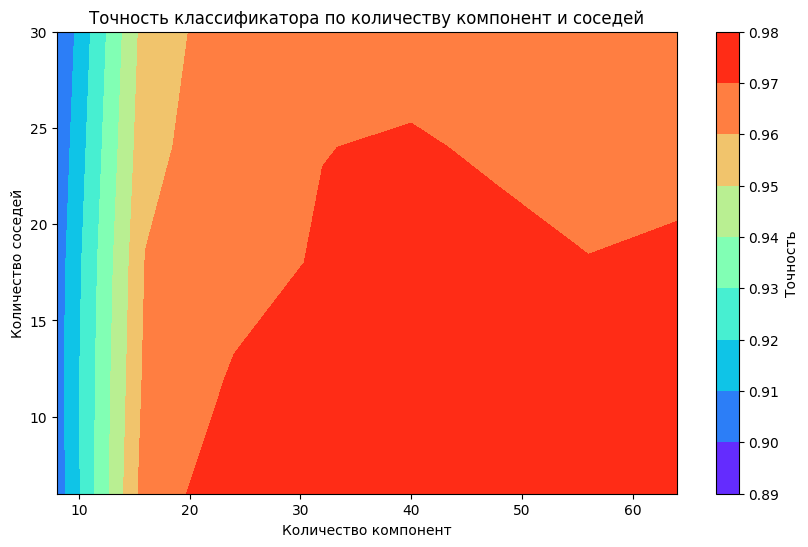

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(8, 65, 8)
y = np.arange(6, 31, 6)
X, Y = np.meshgrid(x, y)
Z = accuracies.T

surf = ax.contourf(X, Y, Z, cmap='rainbow')
cbar = plt.colorbar(surf)

ax.set_xlabel('Количество компонент')
ax.set_ylabel('Количество соседей')
cbar.set_label('Точность')

plt.title('Точность классификатора по количеству компонент и соседей')
plt.show()

# Вывод

При применении алгоритма k-ближайших соседей (kNN) на данных, преобразованных с использованием PCA, была достигнута точность 0.9756363636363636 с наилучшими параметрами: 24 компонент и 6 соседей. 

PCA позволяет снизить размерность данных, сохраняя при этом наиболее важные характеристики. Это может быть полезно для улучшения эффективности алгоритмов машинного обучения и сокращения времени обучения. Комбинация PCA и kNN представляет собой мощный инструмент для классификации данных. Она позволяет учесть влияние наиболее информативных компонент и учитывать близость к соседним объектам при принятии решений. Однако стоит отметить, что выбор оптимальных параметров для PCA (количество компонент) и kNN (количество соседей) может потребовать некоторого исследования и настройки. В данном случае была использована реализация PCA и kNN, созданная самостоятельно. Однако существуют и другие библиотечные реализации этих алгоритмов, которые могут быть удобными и эффективными в реальных задачах. 

В целом, применение PCA и kNN вместе может быть полезным инструментом для анализа и классификации данных, и эти методы могут быть применены в различных областях, включая компьютерное зрение, распознавание образов, биометрию и другие.

In [ ]:
#gay